# Walk through of the current method of hit detection

In [15]:
"""
Generate images of ATTPC events for CNN

Author: Gray Selby
"""
import math
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
import os
import pytpc
from random import shuffle
import pandas as pd

In [363]:
# Python program to get average of a list 
def _average(lst): 
    return sum(lst) / len(lst)

def _l(a):
    return 0 if a == 0 else math.log10(a)

# Threshold charge value used to determine a 'hit' on a pad if
# the max - min of the trace is greater than
THRESHOLD = 55
# The number of pads in the AT-TPC
NUMBEROFPADS = 10240
WINDOWSIZE = 50

In [365]:
data = []

with pytpc.HDFDataFile('corrected_run_0210.h5', 'r') as events:
    event = events[1]
    xyzs = event.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)

In [348]:
event_trace = np.ndarray(10240, dtype=object)
# Get the events trace across each pad
with h5py.File('corrected_run_0210.h5', 'r') as f:
    dset = f['get/1']
    trace = dset[:,10:510]
    TRACELENGTH = len(trace[0])       #500
    for pad in range(NUMBEROFPADS):
        y = np.zeros(TRACELENGTH)
        pad_number = dset[pad,4]
        current_pad = trace[pad]
        for j in range(TRACELENGTH):
            y[j] = current_pad[j]
        event_trace[pad_number] = y

# alternative method

In [366]:
with h5py.File('corrected_run_0210.h5', 'r') as f:
    dset = f['get/1']
    event_data = dset[:,10:510]    #traces for all pads
    
    #determine if a pad was 'hit'
    pads_to_plot = []
    for pad in range(NUMBEROFPADS):
        trace = event_data[pad]    #trace
        trace_max = np.amax(trace)  #max of trace
        trace_average = _average(trace)  #average of trace
        charge = trace_max - trace_average  #charge value
        peak_time = np.argmax(trace)   #time value of peak charge
        for timebuck in range(25,475):
            firstvalue = trace[timebucket-25]
            middlevalue = trace[timebucket]
            lastvalue = trace[timebucket+25]
            average_first_last = (firstvalue+lastvalue)*0.5
            peakheight = middlevalue - average_first_last
            if peakheight > THRESHOLD:
                pads_to_plot.append([peak_time, charge, int(i)])
                break
    np.asarray(pads_to_plot)
    PADSTOPLOTLENGTH = len(pads_to_plot)
    
    # Merge pytpc xyzs array with correct charge values
    plot_points = np.zeros(shape=(PADSTOPLOTLENGTH,4))
    
    for i in range(PADSTOPLOTLENGTH):
        pads_to_plot_padnum = pads_to_plot[i][2]
        for j in range(NUMBEROFPADS):
            xyzs_padnum = xyzs[j][4]
            if(pads_to_plot_padnum == xyzs_padnum):
                plot_points[i][0] = xyzs[j][0]       #x
                plot_points[i][1] = xyzs[j][1]       #y
                plot_points[i][2] = pads_to_plot[i][0]   #time
                plot_points[i][3] = pads_to_plot[i][1]   #charge

    data.append(plot_points)

In [349]:
# Find the correct peak charge value for each trace
hit_peaks = []
WINDOWSIZE = 50
for i in range(NUMBEROFPADS):                      
    trace = event_trace[i]                         
    #traceMax, trace_average = np.amax(trace), _average(trace)
    trace_max = np.amax(trace)
    trace_average = _average(trace)
    charge = trace_max - trace_average
    peak_time = np.argmax(trace)
    for timebucket in range(25,475): #move window across trace
        #firstvalue, middlevalue, lastvalue = trace[timebucket-25], trace[timebucket], trace[timebucket+25]
        firstvalue = trace[timebucket-25]
        middlevalue = trace[timebucket]
        lastvalue = trace[timebucket+25]
        #average_first_last, peakheight = (firstvalue+lastvalue)*0.5, middlevalue - average_first_last
        average_first_last = (firstvalue+lastvalue)*0.5
        peakheight = middlevalue - average_first_last
        if peakheight > THRESHOLD:
            hit_peaks.append([peak_time, charge, int(i)])
                                #  time     charge   padnumber
            break
np.asarray(hit_peaks)                               #convert list to array

array([[3.72000e+02, 2.43380e+02, 0.00000e+00],
       [3.70000e+02, 1.02650e+02, 1.00000e+00],
       [3.71000e+02, 5.31600e+01, 9.00000e+00],
       ...,
       [3.67000e+02, 6.80420e+01, 9.60700e+03],
       [3.66000e+02, 7.38700e+01, 9.60800e+03],
       [3.68000e+02, 2.52856e+02, 9.69100e+03]])

In [350]:
HITPEAKSLENGTH = len(hit_peaks)
# Merge pytpc xyzs array with correct charge values
plot_points = np.zeros(shape=(HITPEAKSLENGTH,4))
for i in range(HITPEAKSLENGTH):
    hitpeaks_padnum = hit_peaks[i][2]
    for j in range(NUMBEROFPADS):
        xyzs_padnum = xyzs[j][4]
        if(hitpeaks_padnum == xyzs_padnum):
            plot_points[i][0] = xyzs[j][0]       #x
            plot_points[i][1] = xyzs[j][1]       #y
            plot_points[i][2] = hit_peaks[i][0]   #time
            plot_points[i][3] = hit_peaks[i][1]   #charge

data.append(plot_points)

In [351]:
# Take the log of charge data
log = np.vectorize(_l)

for event in data:
    event[:,3] = log(event[:,3])

# Normalize
max_charge = np.array(list(map(lambda x: x[:, 3].max(),data))).max()

for e in data:
    for point in e:
        point[3] = point[3] / max_charge

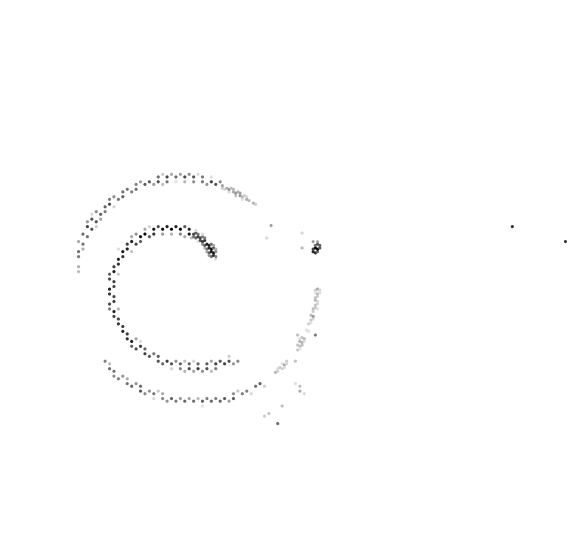

In [352]:
# Make numpy set
images = np.empty((len(data), 128, 128, 3), dtype=np.uint8)

e = data[0]
x = e[:, 0]
y = e[:, 1]
charge = e[:, 3]
fig = plt.figure(figsize=(5, 5), dpi=128)
plt.xlim(-275.0, 275.0)
plt.ylim((-275.0, 275.0))
plt.axis('off')
plt.scatter(x, y, s=0.6, c=charge, cmap='gray_r')
plt.show()

### investigate pad trace fitting
## my testing and working out the new method

In [169]:
charge_foreach_pad = np.ndarray(10240, dtype=object)    #list to hold arrays of charge for each pad
pads_witha_hit = np.zeros(10240)                        #array to have a value of 1 for pad(index) with a "hit" (charge>500)
with h5py.File('corrected_run_0210.h5', 'r') as f:
    #===================== for event 1 ================================
    dset = f['get/1']                                   #dset.shape (10240, 517) corresping to (pads, time)
    dset = dset[:,6:518]                               #removes first 5 columns
    #dset = dset[:,10:510]                           
    for i in range(len(dset)):                          #i from 0 to 10240 for each pad
        pad = dset[i]                                   #select pad from dset 
        y = np.zeros(len(dset[0]))#512)                 #[512] array to hold charge values
        for j in range(len(dset[0])):                   #j from 0 to 512 for time values
            if pad[j] >= 500:                           #if charge at time value is above 500
                pads_witha_hit[i] = 1
            y[j] = pad[j]
        charge_foreach_pad[i] = y                       #add pads charge values to charge_perpad list    

In [19]:
peaks=pd.read_csv('padswithahitevent1.csv')             #manually picked out well defined peaks
peak_padnum = peaks['Pad Numbers']                      #array of pad nums showing defined peaks

use a window of 50 time buckets. if the first part is one number, the middle is a high number, and the end is similar to the first number, then it is a hit

In [95]:
# pads to test preformance, T if analyized as a hit, F otherwise
# all were correct
pads = [5771, 6097, 6691, 9890, 2411, 2427, 2431, 2442, 3325, 3331, 3570, 5494, 5541, 8095, 8396]
#        T     T     T     T     T     F     T     T      T    T      T    T     F     T      F

In [196]:
# Python program to get average of a list 
def _average(lst): 
    return sum(lst) / len(lst)

0
336.0
338.0
338.0
337.0
335.0
337.0
338.0
340.0
340.0
341.0
340.0
340.0
340.0
339.0
340.0
339.0
337.0
338.0
341.0
338.0
343.0
341.0
345.0
348.0
345.0
346.0
349.0
344.0
342.0
343.0
339.0
340.0
338.0
339.0
336.0
337.0
341.0
341.0
342.0
346.0
348.0
348.0
345.0
345.0
347.0
345.0
341.0
344.0
343.0
343.0
341.0
342.0
342.0
342.0
345.0
342.0
347.0
347.0
346.0
346.0
342.0
344.0
345.0
340.0
341.0
337.0
337.0
336.0
341.0
341.0
339.0
343.0
339.0
340.0
344.0
340.0
346.0
343.0
341.0
344.0
343.0
342.0
347.0
348.0
347.0
348.0
346.0
349.0
350.0
352.0
349.0
347.0
348.0
349.0
344.0
343.0
342.0
348.0
347.0
344.0
346.0
346.0
343.0
349.0
350.0
353.0
350.0
353.0
352.0
350.0
349.0
343.0
343.0
342.0
341.0
342.0
346.0
340.0
345.0
345.0
348.0
347.0
345.0
346.0
348.0
346.0
345.0
345.0
344.0
346.0
347.0
346.0
347.0
345.0
342.0
348.0
348.0
350.0
352.0
348.0
352.0
352.0
352.0
352.0
350.0
345.0
351.0
346.0
347.0
344.0
349.0
348.0
350.0
348.0
348.0
348.0
344.0
347.0
349.0
350.0
353.0
354.0
352.0
350.0
349.0
352.0
34

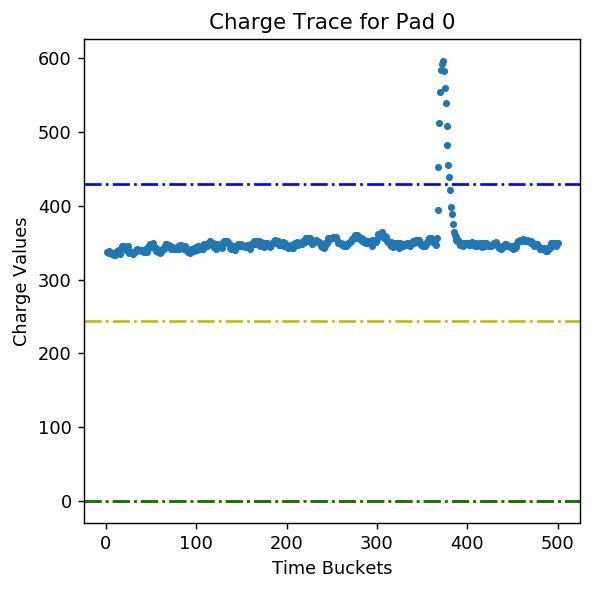

1
336.0
339.0
341.0
342.0
345.0
341.0
339.0
342.0
338.0
337.0
337.0
337.0
338.0
338.0
334.0
332.0
334.0
334.0
335.0
334.0
334.0
335.0
333.0
333.0
337.0
334.0
333.0
338.0
339.0
336.0
340.0
336.0
339.0
342.0
345.0
344.0
341.0
343.0
342.0
339.0
339.0
337.0
334.0
335.0
335.0
332.0
337.0
336.0
340.0
336.0
341.0
341.0
341.0
339.0
340.0
339.0
341.0
343.0
337.0
343.0
341.0
341.0
338.0
337.0
337.0
339.0
337.0
341.0
340.0
337.0
343.0
343.0
344.0
343.0
342.0
344.0
346.0
342.0
345.0
346.0
348.0
342.0
344.0
346.0
343.0
342.0
341.0
340.0
342.0
344.0
343.0
342.0
338.0
343.0
339.0
339.0
340.0
339.0
344.0
346.0
344.0
342.0
345.0
346.0
343.0
342.0
344.0
347.0
347.0
350.0
347.0
348.0
346.0
349.0
349.0
347.0
349.0
347.0
344.0
345.0
344.0
344.0
345.0
347.0
348.0
350.0
350.0
355.0
351.0
350.0
350.0
350.0
352.0
353.0
351.0
348.0
349.0
346.0
349.0
348.0
345.0
348.0
347.0
351.0
347.0
348.0
349.0
350.0
346.0
344.0
345.0
343.0
340.0
344.0
341.0
344.0
343.0
346.0
343.0
344.0
344.0
348.0
344.0
351.0
344.0
345.0
34

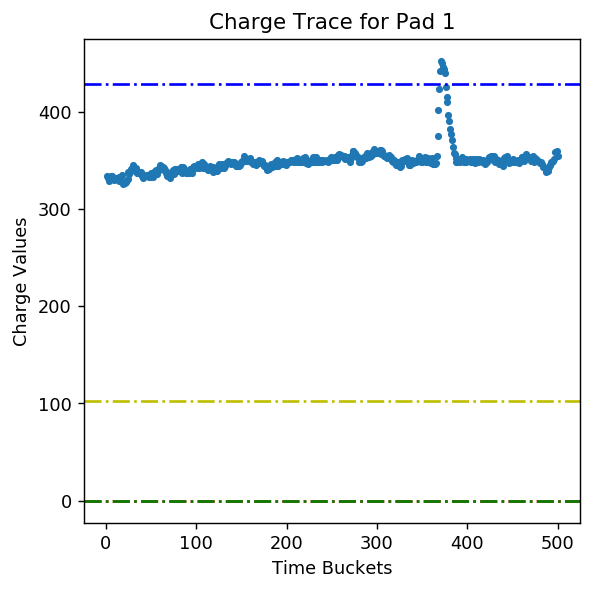

9
447.0
443.0
446.0
445.0
446.0
445.0
443.0
446.0
442.0
439.0
439.0
438.0
441.0
442.0
442.0
445.0
448.0
440.0
443.0
447.0
441.0
441.0
445.0
444.0
445.0
440.0
445.0
443.0
446.0
445.0
447.0
448.0
448.0
450.0
445.0
446.0
446.0
449.0
449.0
446.0
446.0
444.0
443.0
445.0
443.0
444.0
444.0
443.0
446.0
443.0
441.0
446.0
446.0
441.0
443.0
444.0
443.0
445.0
443.0
443.0
446.0
443.0
446.0
447.0
450.0
448.0
449.0
448.0
448.0
452.0
451.0
454.0
451.0
448.0
448.0
447.0
452.0
448.0
450.0
450.0
452.0
451.0
450.0
445.0
449.0
448.0
447.0
446.0
448.0
448.0
449.0
447.0
444.0
442.0
446.0
447.0
445.0
450.0
452.0
449.0
448.0
446.0
445.0
448.0
445.0
449.0
449.0
455.0
451.0
451.0
448.0
449.0
450.0
455.0
452.0
453.0
454.0
453.0
454.0
454.0
453.0
452.0
452.0
451.0
452.0
453.0
455.0
453.0
455.0
457.0
458.0
456.0
455.0
452.0
454.0
456.0
457.0
458.0
458.0
458.0
454.0
449.0
450.0
446.0
449.0
447.0
448.0
450.0
444.0
450.0
455.0
451.0
450.0
452.0
455.0
455.0
456.0
460.0
460.0
457.0
459.0
455.0
456.0
451.0
454.0
452.0
45

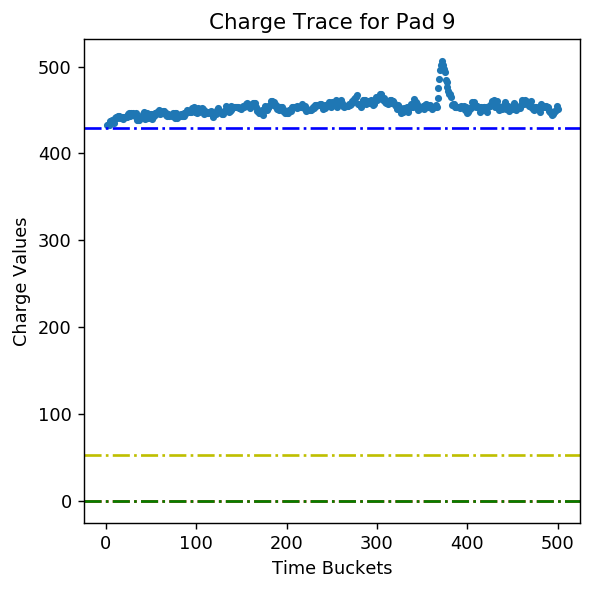

10
397.0
400.0
399.0
400.0
404.0
403.0
404.0
407.0
406.0
405.0
398.0
402.0
401.0
402.0
399.0
399.0
398.0
401.0
402.0
404.0
397.0
400.0
402.0
402.0
404.0
404.0
404.0
407.0
408.0
409.0
404.0
404.0
402.0
402.0
401.0
404.0
402.0
403.0
399.0
402.0
404.0
403.0
407.0
403.0
407.0
402.0
401.0
405.0
404.0
404.0
405.0
404.0
405.0
409.0
407.0
407.0
405.0
403.0
401.0
401.0
400.0
400.0
401.0
405.0
403.0
407.0
405.0
409.0
407.0
407.0
406.0
405.0
407.0
402.0
403.0
407.0
402.0
402.0
403.0
405.0
408.0
405.0
407.0
407.0
407.0
406.0
409.0
412.0
410.0
408.0
409.0
406.0
409.0
411.0
409.0
412.0
408.0
412.0
407.0
408.0
406.0
407.0
406.0
402.0
408.0
407.0
403.0
403.0
404.0
405.0
402.0
405.0
404.0
406.0
409.0
405.0
409.0
405.0
407.0
411.0
409.0
410.0
411.0
413.0
407.0
412.0
414.0
412.0
409.0
408.0
406.0
413.0
411.0
410.0
414.0
413.0
409.0
410.0
410.0
405.0
405.0
407.0
408.0
413.0
410.0
414.0
413.0
408.0
406.0
406.0
408.0
410.0
409.0
409.0
408.0
408.0
403.0
401.0
399.0
403.0
404.0
406.0
406.0
405.0
403.0
406.0
4

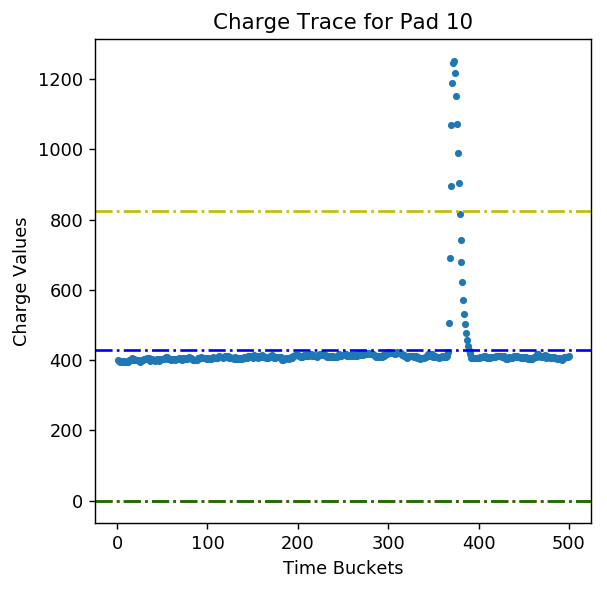

11
409.0
409.0
408.0
408.0
407.0
411.0
410.0
407.0
404.0
406.0
407.0
402.0
407.0
406.0
403.0
405.0
406.0
405.0
407.0
408.0
407.0
410.0
407.0
411.0
411.0
410.0
408.0
407.0
409.0
410.0
408.0
408.0
408.0
412.0
408.0
410.0
412.0
412.0
410.0
409.0
409.0
409.0
407.0
405.0
408.0
409.0
410.0
410.0
410.0
414.0
414.0
410.0
415.0
413.0
409.0
409.0
410.0
409.0
409.0
411.0
411.0
414.0
414.0
413.0
412.0
412.0
414.0
410.0
412.0
412.0
411.0
413.0
410.0
414.0
413.0
415.0
414.0
411.0
412.0
411.0
412.0
410.0
410.0
410.0
409.0
414.0
412.0
408.0
412.0
412.0
407.0
409.0
409.0
411.0
411.0
408.0
411.0
412.0
412.0
415.0
415.0
417.0
418.0
414.0
418.0
414.0
415.0
413.0
410.0
410.0
412.0
411.0
415.0
413.0
412.0
412.0
414.0
414.0
410.0
412.0
407.0
414.0
409.0
415.0
413.0
413.0
413.0
412.0
417.0
417.0
416.0
415.0
419.0
413.0
414.0
414.0
417.0
415.0
418.0
415.0
413.0
409.0
415.0
413.0
415.0
414.0
414.0
411.0
411.0
410.0
410.0
408.0
412.0
414.0
417.0
414.0
413.0
415.0
414.0
417.0
417.0
417.0
417.0
418.0
416.0
415.0
4

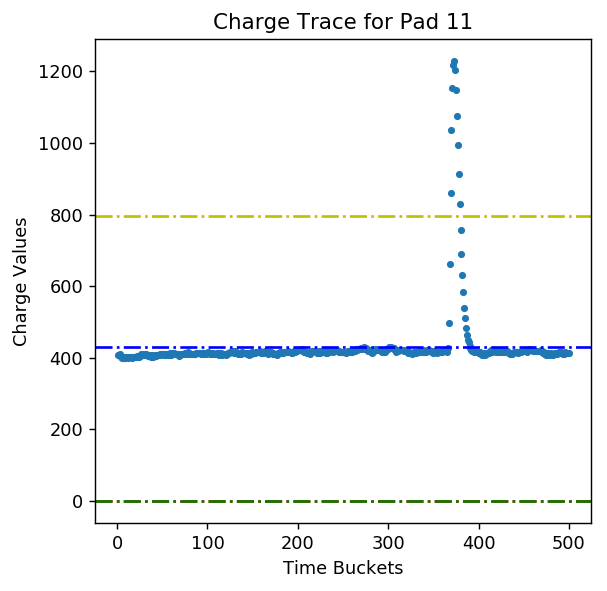

12
389.0
384.0
385.0
384.0
382.0
384.0
387.0
386.0
385.0
385.0
389.0
388.0
389.0
390.0
386.0
392.0
390.0
390.0
389.0
387.0
385.0
387.0
390.0
391.0
395.0
397.0
396.0
395.0
397.0
397.0
396.0
396.0
394.0
394.0
393.0
394.0
397.0
393.0
393.0
397.0
393.0
393.0
394.0
396.0
396.0
397.0
398.0
398.0
397.0
396.0
393.0
394.0
397.0
396.0
397.0
395.0
400.0
398.0
397.0
400.0
398.0
396.0
397.0
397.0
396.0
395.0
397.0
399.0
395.0
397.0
402.0
404.0
401.0
402.0
397.0
400.0
398.0
398.0
397.0
398.0
400.0
394.0
397.0
396.0
390.0
394.0
394.0
396.0
397.0
396.0
393.0
393.0
387.0
393.0
393.0
391.0
394.0
394.0
394.0
394.0
389.0
392.0
391.0
395.0
396.0
400.0
400.0
403.0
401.0
400.0
403.0
400.0
400.0
396.0
401.0
401.0
401.0
401.0
400.0
400.0
400.0
401.0
402.0
404.0
404.0
405.0
401.0
401.0
405.0
401.0
404.0
405.0
400.0
403.0
403.0
399.0
404.0
402.0
398.0
402.0
403.0
405.0
405.0
403.0
403.0
403.0
403.0
403.0
402.0
401.0
402.0
403.0
403.0
408.0
405.0
400.0
400.0
404.0
403.0
405.0
402.0
403.0
403.0
401.0
407.0
405.0
4

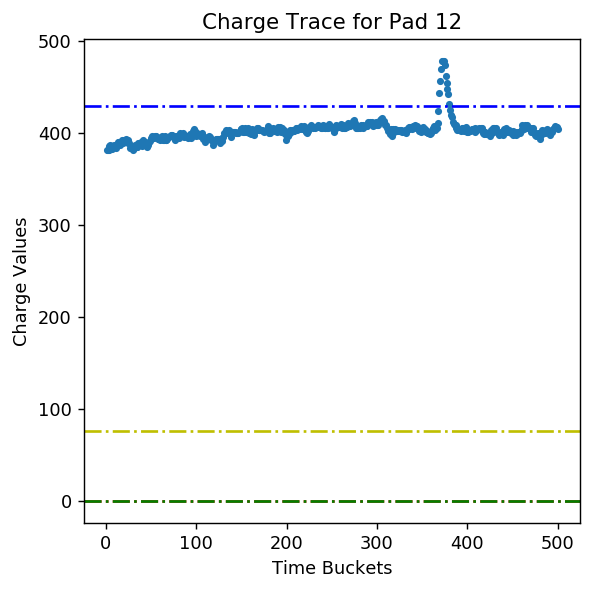

44
339.0
330.0
336.0
332.0
333.0
333.0
335.0
335.0
337.0
338.0
339.0
333.0
334.0
336.0
337.0
337.0
335.0
339.0
338.0
339.0
340.0
340.0
339.0
340.0
341.0
341.0
341.0
343.0
344.0
342.0
337.0
337.0
341.0
341.0
337.0
340.0
341.0
343.0
341.0
347.0
348.0
350.0
346.0
346.0
347.0
349.0
347.0
348.0
347.0
349.0
344.0
343.0
342.0
344.0
339.0
341.0
340.0
338.0
343.0
342.0
343.0
342.0
341.0
341.0
344.0
341.0
342.0
347.0
343.0
339.0
343.0
344.0
347.0
345.0
344.0
346.0
343.0
344.0
345.0
344.0
349.0
348.0
351.0
352.0
355.0
358.0
355.0
351.0
354.0
350.0
352.0
351.0
344.0
348.0
350.0
347.0
348.0
347.0
351.0
346.0
344.0
342.0
350.0
349.0
343.0
346.0
347.0
340.0
342.0
339.0
341.0
341.0
338.0
340.0
337.0
339.0
340.0
341.0
341.0
341.0
344.0
345.0
346.0
347.0
346.0
350.0
347.0
345.0
346.0
349.0
347.0
348.0
347.0
346.0
346.0
344.0
344.0
346.0
344.0
349.0
349.0
349.0
349.0
347.0
351.0
354.0
352.0
352.0
354.0
356.0
354.0
354.0
351.0
350.0
353.0
351.0
350.0
346.0
351.0
351.0
354.0
350.0
349.0
352.0
348.0
351.0
3

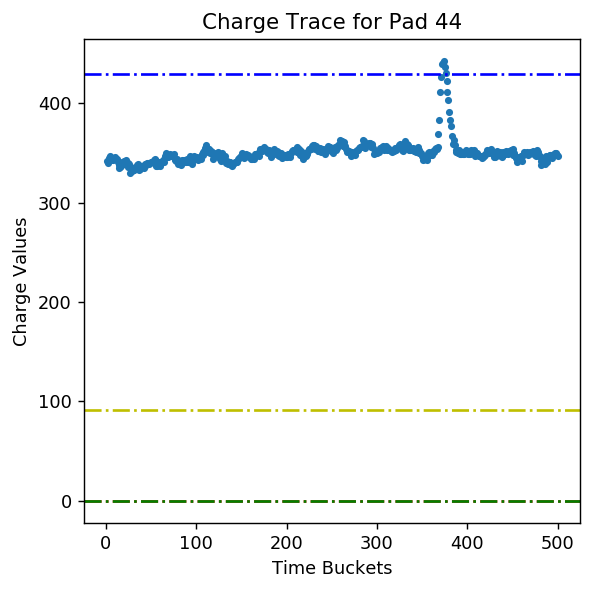

45
343.0
344.0
345.0
347.0
347.0
346.0
348.0
345.0
349.0
346.0
344.0
346.0
345.0
345.0
345.0
342.0
343.0
344.0
345.0
345.0
347.0
347.0
346.0
343.0
346.0
349.0
346.0
349.0
346.0
349.0
352.0
347.0
350.0
352.0
353.0
350.0
352.0
353.0
350.0
347.0
349.0
348.0
349.0
353.0
346.0
349.0
348.0
347.0
347.0
350.0
343.0
347.0
345.0
342.0
347.0
346.0
348.0
344.0
346.0
347.0
346.0
345.0
345.0
350.0
347.0
347.0
350.0
350.0
354.0
354.0
353.0
351.0
353.0
351.0
347.0
352.0
351.0
353.0
358.0
354.0
354.0
356.0
357.0
357.0
355.0
355.0
357.0
354.0
354.0
352.0
353.0
350.0
348.0
349.0
346.0
347.0
341.0
343.0
343.0
345.0
344.0
346.0
345.0
347.0
348.0
348.0
348.0
346.0
348.0
351.0
351.0
353.0
352.0
349.0
347.0
347.0
349.0
349.0
352.0
349.0
354.0
355.0
356.0
356.0
354.0
358.0
354.0
352.0
352.0
350.0
348.0
350.0
352.0
350.0
354.0
353.0
351.0
353.0
354.0
353.0
356.0
355.0
356.0
356.0
355.0
354.0
354.0
355.0
352.0
352.0
348.0
345.0
347.0
345.0
349.0
348.0
350.0
356.0
356.0
354.0
357.0
359.0
355.0
355.0
357.0
356.0
3

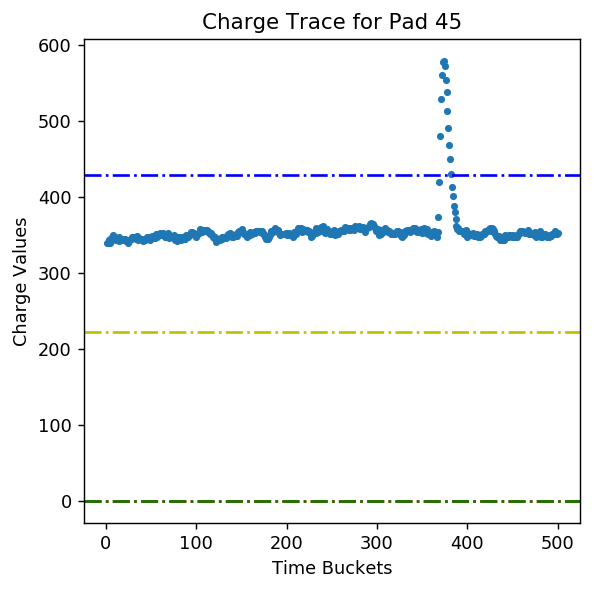

46
311.0
314.0
312.0
311.0
312.0
317.0
318.0
316.0
316.0
320.0
317.0
317.0
321.0
319.0
318.0
313.0
316.0
315.0
310.0
315.0
313.0
314.0
318.0
315.0
317.0
316.0
319.0
318.0
317.0
315.0
318.0
313.0
313.0
312.0
315.0
316.0
312.0
312.0
309.0
309.0
312.0
312.0
313.0
314.0
315.0
311.0
317.0
316.0
317.0
317.0
315.0
317.0
317.0
313.0
317.0
318.0
316.0
310.0
312.0
313.0
314.0
313.0
315.0
313.0
310.0
309.0
311.0
311.0
314.0
313.0
314.0
313.0
316.0
313.0
319.0
317.0
321.0
324.0
327.0
328.0
334.0
331.0
331.0
332.0
330.0
327.0
330.0
327.0
325.0
321.0
319.0
319.0
317.0
311.0
311.0
315.0
317.0
317.0
315.0
316.0
315.0
320.0
317.0
311.0
318.0
315.0
318.0
320.0
321.0
322.0
318.0
319.0
316.0
316.0
315.0
316.0
315.0
323.0
319.0
317.0
316.0
315.0
316.0
318.0
321.0
317.0
320.0
319.0
319.0
318.0
315.0
320.0
321.0
320.0
320.0
324.0
320.0
320.0
320.0
319.0
320.0
315.0
318.0
321.0
322.0
319.0
318.0
320.0
321.0
319.0
322.0
319.0
320.0
320.0
319.0
316.0
316.0
318.0
315.0
317.0
317.0
319.0
315.0
315.0
313.0
315.0
3

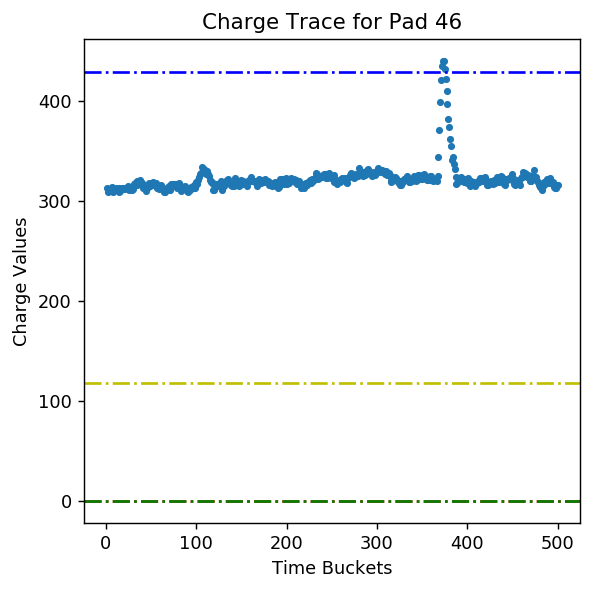

47
404.0
406.0
407.0
402.0
405.0
408.0
405.0
402.0
403.0
403.0
404.0
406.0
407.0
409.0
411.0
409.0
409.0
408.0
405.0
406.0
400.0
403.0
403.0
402.0
404.0
400.0
403.0
405.0
406.0
407.0
409.0
411.0
411.0
409.0
410.0
412.0
410.0
410.0
408.0
414.0
408.0
410.0
406.0
403.0
403.0
402.0
403.0
400.0
406.0
409.0
411.0
409.0
410.0
409.0
407.0
409.0
408.0
410.0
409.0
405.0
409.0
407.0
403.0
404.0
405.0
406.0
405.0
404.0
407.0
408.0
406.0
409.0
407.0
405.0
404.0
409.0
410.0
409.0
410.0
409.0
413.0
410.0
408.0
406.0
406.0
405.0
406.0
408.0
413.0
411.0
415.0
416.0
417.0
412.0
411.0
413.0
413.0
412.0
408.0
408.0
408.0
408.0
410.0
408.0
407.0
410.0
407.0
407.0
412.0
411.0
411.0
415.0
412.0
411.0
410.0
412.0
406.0
406.0
407.0
406.0
407.0
404.0
404.0
406.0
404.0
409.0
406.0
407.0
408.0
409.0
411.0
408.0
409.0
409.0
408.0
408.0
411.0
407.0
408.0
408.0
411.0
414.0
413.0
412.0
415.0
412.0
411.0
409.0
412.0
409.0
409.0
411.0
411.0
410.0
414.0
411.0
414.0
413.0
418.0
421.0
420.0
416.0
417.0
413.0
412.0
414.0
4

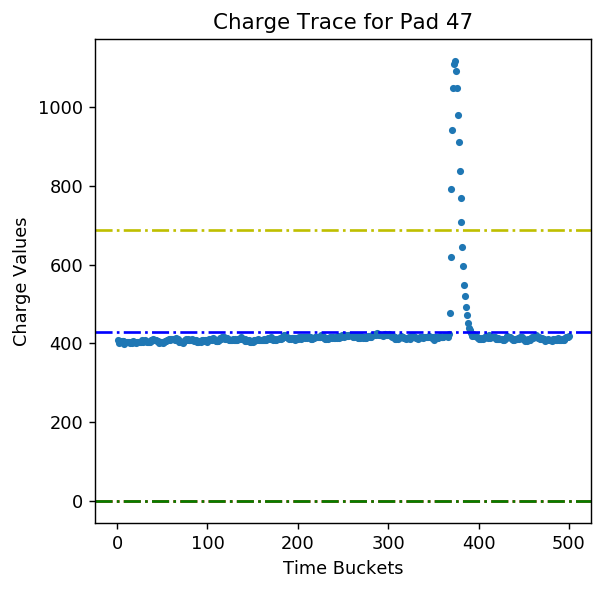

48
351.0
350.0
347.0
347.0
350.0
349.0
350.0
348.0
349.0
350.0
351.0
349.0
354.0
357.0
352.0
350.0
354.0
349.0
347.0
349.0
350.0
346.0
353.0
355.0
357.0
352.0
353.0
355.0
356.0
356.0
360.0
356.0
354.0
358.0
356.0
357.0
358.0
353.0
355.0
350.0
350.0
350.0
350.0
349.0
348.0
350.0
350.0
355.0
355.0
355.0
355.0
359.0
356.0
353.0
352.0
348.0
348.0
350.0
350.0
351.0
350.0
348.0
349.0
349.0
347.0
351.0
347.0
350.0
350.0
355.0
355.0
355.0
357.0
357.0
357.0
357.0
362.0
359.0
363.0
362.0
363.0
365.0
362.0
362.0
364.0
361.0
362.0
365.0
364.0
361.0
358.0
356.0
354.0
354.0
350.0
354.0
352.0
352.0
355.0
355.0
355.0
353.0
353.0
351.0
353.0
351.0
352.0
355.0
350.0
349.0
353.0
351.0
353.0
355.0
356.0
357.0
357.0
357.0
361.0
361.0
359.0
357.0
358.0
356.0
356.0
357.0
355.0
353.0
351.0
356.0
354.0
355.0
352.0
355.0
356.0
358.0
351.0
355.0
354.0
359.0
355.0
355.0
355.0
355.0
357.0
354.0
352.0
354.0
355.0
356.0
353.0
355.0
351.0
352.0
354.0
356.0
357.0
355.0
361.0
363.0
359.0
357.0
360.0
355.0
353.0
355.0
3

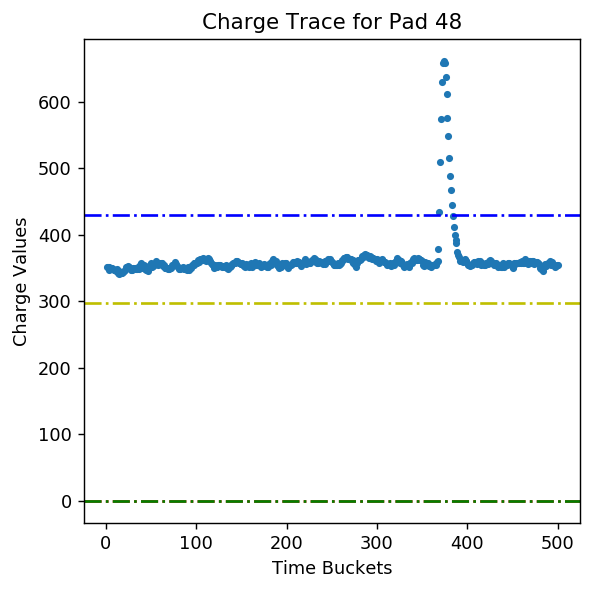

49
349.0
355.0
355.0
356.0
355.0
356.0
358.0
356.0
354.0
356.0
353.0
350.0
353.0
352.0
352.0
353.0
352.0
354.0
355.0
355.0
355.0
349.0
351.0
352.0
356.0
358.0
357.0
356.0
358.0
358.0
359.0
358.0
359.0
357.0
358.0
358.0
355.0
359.0
355.0
357.0
355.0
350.0
351.0
351.0
352.0
353.0
352.0
353.0
356.0
357.0
357.0
358.0
357.0
356.0
356.0
355.0
355.0
356.0
352.0
353.0
352.0
351.0
352.0
353.0
352.0
352.0
351.0
353.0
357.0
356.0
357.0
356.0
359.0
356.0
358.0
359.0
362.0
360.0
361.0
360.0
359.0
357.0
356.0
355.0
356.0
357.0
359.0
359.0
359.0
359.0
359.0
356.0
358.0
356.0
354.0
357.0
359.0
354.0
353.0
355.0
353.0
355.0
353.0
357.0
359.0
359.0
360.0
362.0
356.0
362.0
364.0
358.0
356.0
357.0
357.0
354.0
354.0
352.0
355.0
350.0
353.0
350.0
351.0
355.0
354.0
356.0
357.0
362.0
360.0
357.0
360.0
359.0
361.0
358.0
363.0
362.0
359.0
358.0
359.0
359.0
356.0
354.0
356.0
356.0
354.0
354.0
354.0
358.0
357.0
358.0
358.0
357.0
355.0
356.0
359.0
357.0
355.0
355.0
356.0
356.0
355.0
357.0
362.0
361.0
359.0
360.0
3

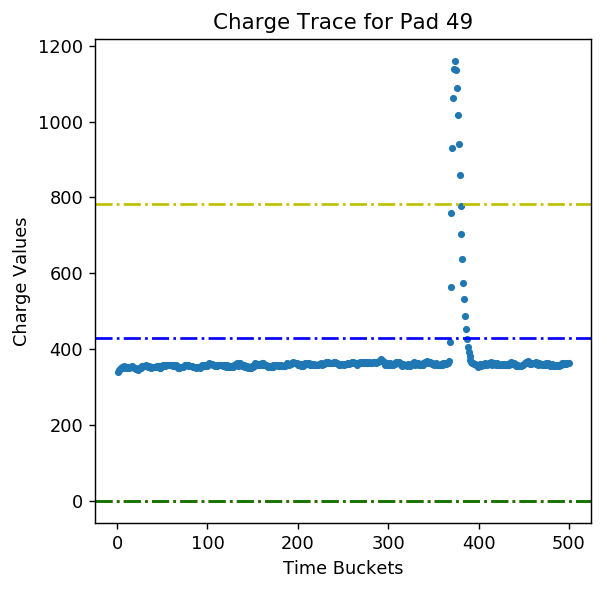

50
250.0
248.0
254.0
248.0
250.0
249.0
252.0
249.0
248.0
251.0
245.0
249.0
248.0
246.0
244.0
247.0
248.0
249.0
252.0
249.0
253.0
255.0
252.0
254.0
251.0
250.0
251.0
248.0
249.0
245.0
246.0
248.0
250.0
256.0
255.0
257.0
254.0
254.0
254.0
252.0
249.0
255.0
252.0
252.0
250.0
256.0
254.0
252.0
252.0
251.0
252.0
256.0
257.0
256.0
259.0
255.0
253.0
254.0
255.0
257.0
260.0
257.0
258.0
257.0
255.0
256.0
252.0
257.0
255.0
259.0
258.0
255.0
254.0
257.0
255.0
256.0
258.0
259.0
253.0
253.0
255.0
254.0
253.0
254.0
254.0
254.0
254.0
257.0
254.0
251.0
254.0
254.0
256.0
257.0
258.0
258.0
262.0
260.0
257.0
256.0
255.0
258.0
257.0
257.0
257.0
253.0
256.0
256.0
254.0
256.0
254.0
253.0
255.0
256.0
251.0
256.0
260.0
258.0
259.0
260.0
261.0
257.0
260.0
258.0
254.0
253.0
255.0
256.0
254.0
258.0
258.0
260.0
255.0
259.0
258.0
259.0
261.0
258.0
261.0
260.0
255.0
258.0
253.0
256.0
258.0
256.0
257.0
259.0
252.0
256.0
260.0
254.0
258.0
260.0
258.0
261.0
263.0
264.0
263.0
260.0
260.0
255.0
259.0
258.0
259.0
257.0
2

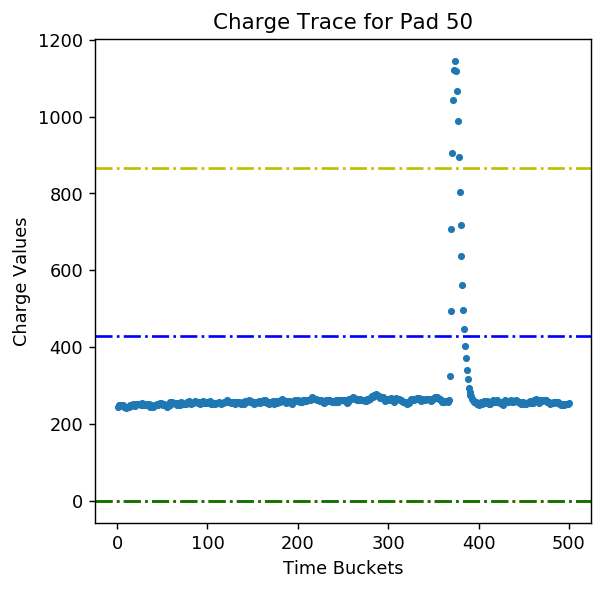

51
274.0
273.0
277.0
275.0
279.0
279.0
280.0
276.0
279.0
276.0
279.0
275.0
276.0
279.0
280.0
280.0
281.0
279.0
281.0
278.0
282.0
278.0
278.0
276.0
278.0
276.0
279.0
281.0
283.0
283.0
283.0
282.0
284.0
282.0
280.0
277.0
275.0
273.0
272.0
275.0
275.0
272.0
274.0
277.0
277.0
277.0
280.0
280.0
275.0
279.0
278.0
278.0
278.0
277.0
277.0
277.0
280.0
279.0
281.0
283.0
280.0
278.0
276.0
278.0
280.0
279.0
279.0
279.0
283.0
281.0
280.0
282.0
279.0
283.0
281.0
283.0
282.0
284.0
281.0
287.0
281.0
288.0
284.0
285.0
285.0
285.0
282.0
282.0
280.0
284.0
285.0
284.0
283.0
283.0
283.0
286.0
284.0
285.0
286.0
286.0
280.0
282.0
283.0
281.0
280.0
278.0
280.0
278.0
279.0
278.0
283.0
281.0
281.0
281.0
276.0
275.0
275.0
278.0
275.0
276.0
279.0
281.0
282.0
281.0
281.0
281.0
281.0
282.0
282.0
281.0
282.0
287.0
285.0
284.0
285.0
284.0
281.0
281.0
278.0
278.0
278.0
278.0
279.0
279.0
281.0
281.0
280.0
282.0
286.0
284.0
282.0
284.0
284.0
284.0
285.0
290.0
288.0
286.0
288.0
285.0
287.0
284.0
282.0
281.0
278.0
277.0
2

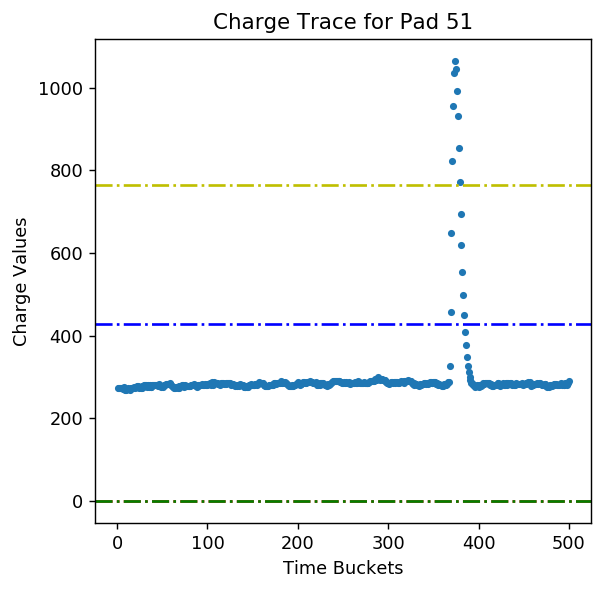

52
372.0
373.0
374.0
373.0
376.0
377.0
377.0
379.0
377.0
377.0
374.0
376.0
373.0
373.0
371.0
372.0
371.0
370.0
367.0
370.0
375.0
375.0
370.0
373.0
371.0
372.0
368.0
371.0
368.0
375.0
375.0
377.0
374.0
375.0
379.0
380.0
378.0
372.0
378.0
376.0
370.0
367.0
372.0
365.0
363.0
366.0
365.0
370.0
371.0
375.0
373.0
372.0
376.0
374.0
375.0
372.0
375.0
374.0
371.0
371.0
372.0
372.0
367.0
370.0
372.0
373.0
375.0
376.0
372.0
376.0
376.0
378.0
375.0
376.0
374.0
376.0
381.0
377.0
379.0
378.0
378.0
378.0
382.0
384.0
381.0
382.0
380.0
381.0
380.0
381.0
376.0
375.0
374.0
374.0
372.0
375.0
373.0
367.0
365.0
367.0
369.0
368.0
363.0
373.0
376.0
375.0
375.0
374.0
377.0
378.0
374.0
375.0
378.0
372.0
372.0
373.0
375.0
373.0
374.0
375.0
375.0
375.0
372.0
374.0
370.0
370.0
372.0
375.0
377.0
377.0
377.0
377.0
377.0
377.0
379.0
377.0
375.0
376.0
375.0
376.0
373.0
375.0
374.0
375.0
374.0
375.0
375.0
374.0
377.0
377.0
377.0
376.0
377.0
376.0
374.0
374.0
374.0
374.0
374.0
377.0
383.0
379.0
382.0
382.0
375.0
379.0
3

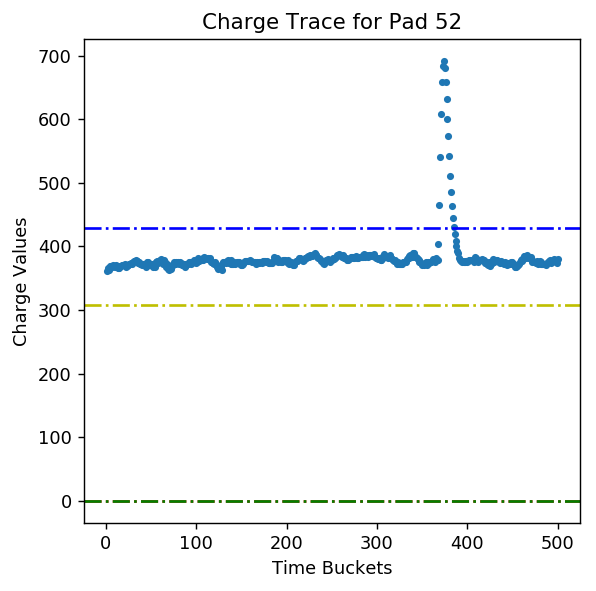

53
304.0
304.0
305.0
303.0
305.0
302.0
307.0
305.0
304.0
303.0
307.0
310.0
306.0
308.0
307.0
305.0
308.0
310.0
308.0
309.0
308.0
311.0
309.0
311.0
310.0
307.0
309.0
308.0
305.0
308.0
304.0
308.0
305.0
304.0
307.0
305.0
308.0
310.0
304.0
311.0
308.0
309.0
307.0
306.0
306.0
307.0
306.0
306.0
307.0
310.0
309.0
308.0
309.0
307.0
308.0
307.0
307.0
306.0
308.0
306.0
309.0
309.0
307.0
309.0
310.0
312.0
315.0
312.0
312.0
311.0
310.0
308.0
306.0
306.0
309.0
308.0
306.0
311.0
313.0
308.0
309.0
311.0
311.0
310.0
311.0
309.0
313.0
309.0
308.0
308.0
310.0
311.0
311.0
310.0
312.0
307.0
309.0
310.0
308.0
307.0
310.0
309.0
306.0
311.0
310.0
311.0
312.0
313.0
314.0
308.0
311.0
310.0
308.0
309.0
307.0
309.0
307.0
307.0
306.0
305.0
307.0
309.0
309.0
308.0
310.0
307.0
309.0
308.0
311.0
311.0
307.0
305.0
307.0
306.0
306.0
309.0
304.0
304.0
303.0
305.0
309.0
309.0
309.0
310.0
313.0
317.0
312.0
314.0
313.0
316.0
314.0
314.0
315.0
312.0
311.0
310.0
311.0
310.0
311.0
308.0
308.0
311.0
306.0
307.0
309.0
312.0
3

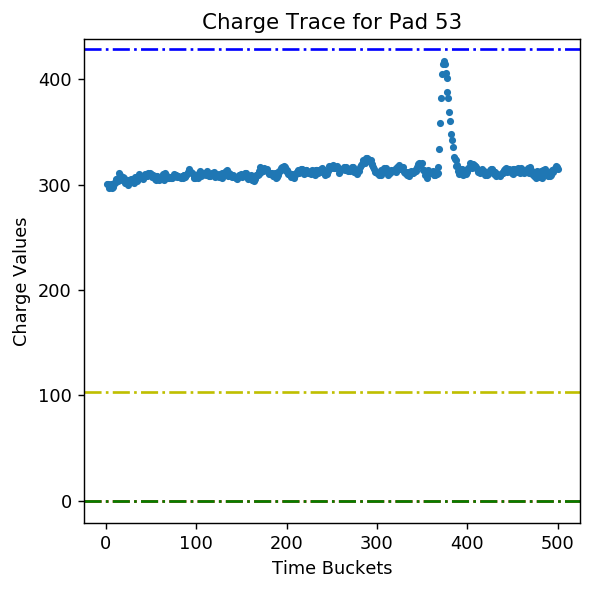

54
386.0
387.0
389.0
385.0
379.0
383.0
383.0
383.0
383.0
381.0
379.0
383.0
381.0
385.0
385.0
382.0
384.0
384.0
384.0
382.0
383.0
386.0
385.0
387.0
389.0
388.0
392.0
391.0
390.0
387.0
388.0
386.0
390.0
388.0
385.0
387.0
389.0
390.0
390.0
387.0
389.0
387.0
386.0
387.0
388.0
389.0
387.0
384.0
383.0
384.0
385.0
385.0
384.0
387.0
385.0
387.0
388.0
390.0
391.0
395.0
389.0
395.0
388.0
392.0
390.0
391.0
390.0
388.0
390.0
388.0
386.0
389.0
387.0
388.0
391.0
387.0
391.0
393.0
395.0
397.0
389.0
394.0
392.0
394.0
393.0
396.0
397.0
396.0
392.0
397.0
395.0
394.0
397.0
394.0
394.0
396.0
392.0
395.0
390.0
392.0
391.0
392.0
390.0
390.0
387.0
388.0
384.0
386.0
387.0
390.0
394.0
395.0
394.0
394.0
394.0
395.0
392.0
395.0
393.0
391.0
394.0
390.0
390.0
389.0
393.0
395.0
394.0
393.0
394.0
399.0
398.0
397.0
398.0
397.0
397.0
396.0
394.0
394.0
395.0
397.0
395.0
394.0
399.0
393.0
393.0
390.0
390.0
389.0
395.0
394.0
394.0
392.0
392.0
390.0
393.0
396.0
398.0
395.0
395.0
397.0
396.0
397.0
394.0
398.0
398.0
400.0
4

KeyboardInterrupt: 

In [362]:
for i in range(len(hit_peaks)):
    padnumber = hit_peaks[i][2]
    print(padnumber)
    padwashit = False
    midval = 0
    timevaluewhendetermined = 0
    firstlastaverage = 0
    fig = py.figure(figsize=(5, 5), dpi=128)
    x = range(1, 501)

    #trace = charge_foreach_pad[padnumber]
    trace = event_trace[padnumber]
    #aveoftrace = _average(trace)
    #maxoftrace = np.amax(trace)
    #charge = maxoftrace - aveoftrace
    windowsize = 50
    
    trace_max = np.amax(trace)
    trace_average = _average(trace)
    charge = trace_max - trace_average
    peak_time = np.argmax(trace)

#     peak_time = np.argmax(trace)
#     print('peak time: '+str(peak_time))
#     print('peak height: '+str(trace[peak_time]))
#     print('amax()  '+str(np.amax(trace)))
#     print('')

    
    average_first_last = (firstvalue+lastvalue)*0.5
    peakheight = middlevalue - average_first_last
    
    #for j in range(25,486): #move window across trace
    for j in range(25,475):
        firstvalue = trace[j-25]
        middlevalue = trace[j]
        lastvalue = trace[j+25]
        #firstlastave = (firstvalue+lastvalue)*0.5
        if peakheight > THRESHOLD:
            padwashit = True
            firstlastaverage = average_first_last
            midval = trace[j]
            charge = trace_max - trace_average
            aveoftrace = _average(trace)
            timevaluewhendetermined = np.argmax(trace)
            #hit_peaks.append([peak_time, charge, int(i)])
                                 #  time     charge   padnumber
            break
            
#         if peakheight > THRESHOLD:
#             padwashit = True
#             midval = middlevalue
#             timevaluewhendetermined = j
#             firstlastaverage = firstlastave
#             break

    py.plot(x, trace, '.')
    plt.axhline(y=firstlastaverage, color='r', linestyle='-.')
    #plt.axhline(y=average_first_last, color='r', linestyle='-.')
    plt.axhline(y=midval, color='g', linestyle='-.')
    #plt.axhline(y=middlevalue, color='g', linestyle='-.')
    plt.axhline(y=charge, color='y', linestyle='-.')
    plt.axhline(y=aveoftrace, color='b', linestyle='-.')
    #plt.axhline(y=trace_average, color='b', linestyle='-.')
    py.title("Charge Trace for Pad "+str(padnumber))      
    py.xlabel("Time Buckets")
    py.ylabel("Charge Values")
    #py.ylim(200,800)

    if padwashit == True:
        print('Pad number: '+str(padnumber)+' is a hit!')
        #print('time value: '+str(peak_time))
        print('time value: '+str(timevaluewhendetermined))
        #print('max of trace: '+str(trace_max)+'   first-last average: '+str(average_first_last))
        print('max of trace: '+str(trace_max)+'   first-last average: '+str(firstlastaverage))
        print('Average of trace: '+str(aveoftrace))
        print('peak charge value: '+str(charge))
    else:
        print('No hit')

    py.show()

peak time: 351
peak height: 879.0
amax()  879.0

Pad number: 2411 is a hit!
time value: 336
max of trace: 879.0   first-last average: 591.5
Average of trace: 424.2348336594912
peak charge value: 454.7651663405088


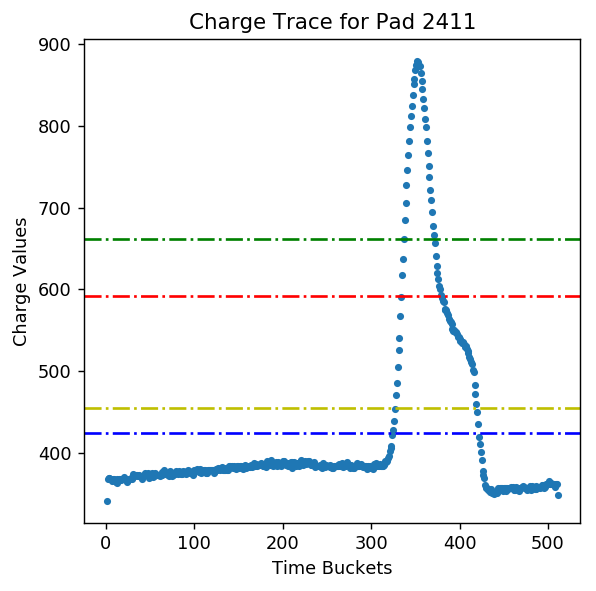

In [307]:
padnumber = pads[4]
padwashit = False
midval = 0
timevaluewhendetermined = 0
firstlastaverage = 0
fig = py.figure(figsize=(5, 5), dpi=128)
x = range(1, 512)

trace = charge_foreach_pad[padnumber]
aveoftrace = _average(trace)
maxoftrace = np.amax(trace)
charge = maxoftrace - aveoftrace
windowsize = 50

peak_time = np.argmax(trace)
print('peak time: '+str(peak_time))
print('peak height: '+str(trace[peak_time]))
print('amax()  '+str(np.amax(trace)))
print('')

for j in range(25,488): #move window across trace
    #start window 25 from begginging of trace
    firstvalue = trace[j-25]
    middlevalue = trace[j]
    lastvalue = trace[j+25]
    firstlastave = (firstvalue+lastvalue)*0.5
    peakheight = middlevalue - firstlastave
    if peakheight > 50:
        padwashit = True
        midval = middlevalue
        timevaluewhendetermined = j
        firstlastaverage = firstlastave
        break

py.plot(x, trace, '.')
plt.axhline(y=firstlastaverage, color='r', linestyle='-.')
plt.axhline(y=midval, color='g', linestyle='-.')
plt.axhline(y=charge, color='y', linestyle='-.')
plt.axhline(y=aveoftrace, color='b', linestyle='-.')
py.title("Charge Trace for Pad "+str(padnumber))      
py.xlabel("Time Buckets")
py.ylabel("Charge Values")
#py.ylim(200,800)

if padwashit:
    print('Pad number: '+str(padnumber)+' is a hit!')
    print('time value: '+str(timevaluewhendetermined))
    print('max of trace: '+str(maxoftrace)+'   first-last average: '+str(firstlastaverage))
    print('Average of trace: '+str(aveoftrace))
    print('peak charge value: '+str(charge))
else:
    print('No hit')

py.show()

### back to original script

In [10]:
HITPEAKSLENGTH = len(hit_peaks)
# Merge pytpc xyzs array with correct charge values
plot_points = np.zeros(shape=(HITPEAKSLENGTH,4))
for i in range(HITPEAKSLENGTH):
    hitpeaks_padnum = hit_peaks[i][2]
    for j in range(NUMBEROFPADS):
        xyzs_padnum = xyzs[j][4]
        if(hitpeaks_padnum == xyzs_padnum):
            plot_points[i][0] = xyzs[j][0]       #x
            plot_points[i][1] = xyzs[j][1]       #y
            plot_points[i][2] = hit_peaks[i][0]   #time
            plot_points[i][3] = hit_peaks[i][1]   #charge

data.append(plot_points)

In [11]:
# Take the log of charge data
log = np.vectorize(_l)

for event in data:
    event[:,3] = log(event[:,3])

# Shuffle data
#data = shuffle(data)

# Normalize
max_charge = np.array(list(map(lambda x: x[:, 3].max(),data))).max()

for e in data:
    for point in e:
        point[3] = point[3] / max_charge

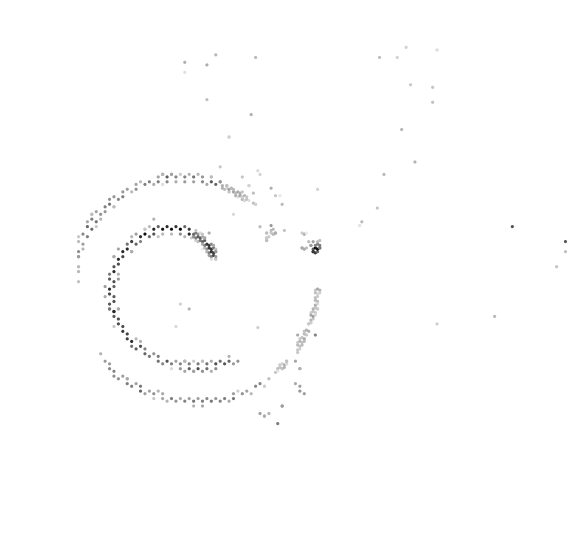

In [14]:
# Make numpy set
images = np.empty((len(data), 128, 128, 3), dtype=np.uint8)

e = data[0]
x = e[:, 0]
y = e[:, 1]
charge = e[:, 3]
fig = plt.figure(figsize=(5, 5), dpi=128)
plt.xlim(-275.0, 275.0)
plt.ylim((-275.0, 275.0))
plt.axis('off')
plt.scatter(x, y, s=0.6, c=charge, cmap='gray_r')
plt.show()

In [ ]:
def real_unlabeled_events(projection, save_path, prefix):
    print('Processing data...')
    data = []

    events = pytpc.HDFDataFile('corrected_run_0210.h5', 'r')
    for x, event in enumerate(events):
        # Get pytpc xyzs
        xyzs = event.xyzs(peaks_only=True, return_pads=True,
            baseline_correction=False, cg_times=False)

        event_trace = np.ndarray(10240, dtype=object)
        # Get the events trace across each pad
        with h5py.File('corrected_run_0210.h5', 'r') as f:
            dset = f['get/'+str(x+1)]
            #trace = dset[:,10:510]
            trace = dset[:,10:510]
            TRACELENGTH = len(trace[0])
            for i in range(NUMBEROFPADS):
                y = np.zeros(TRACELENGTH)
                pad_number = dset[i,4]
                current_pad = trace[i]
                for j in range(TRACELENGTH):
                    y[j] = current_pad[j]
                event_trace[pad_number] = y

        # Find the correct peak charge value for each trace
        hit_peaks = []
        for i in range(NUMBEROFPADS):
#             trace = event_trace[i]
#             traceMax = np.amax(trace)
#             traceMin = np.amin(trace)
#             peak_time_index = []
#             if(traceMax - traceMin > THRESHOLD):
#                 for j in range(TRACELENGTH):
#                     if(np.max(trace) == trace[j]):
#                         peak_time_index.append(j+0.0)
#                 for k in range(len(peak_time_index)):
#                     peak_time = peak_time_index[k]
#                     hit_peaks.append([peak_time, traceMax, i+0.0])
#                                     #  time     charge   padnumber
        trace = event_trace[i]                         
        #traceMax, trace_average = np.amax(trace), _average(trace)
        traceMax = np.amax(trace)
        trace_average = _average(trace)
        charge = maxoftrace - trace_average
        for timebucket in range(25,486): #move window across trace
            #firstvalue, middlevalue, lastvalue = trace[timebucket-25], trace[timebucket], trace[timebucket+25]
            firstvalue = trace[timebucket-25]
            middlevalue = trace[timebucket]
            lastvalue = trace[timebucket+25]
            #average_first_last, peakheight = (firstvalue+lastvalue)*0.5, middlevalue - average_first_last
            average_first_last = (firstvalue+lastvalue)*0.5
            peakheight = middlevalue - average_first_last
            if peakheight > 50:
                hit_peaks.append([timebucket, charge, i+0.0])
                                    #  time     charge   padnumber
                break                
                        
        np.asarray(hit_peaks)
        
        HITPEAKSLENGTH = len(hit_peaks)
        # Merge pytpc xyzs array with correct charge values
        plot_points = np.zeros(shape=(HITPEAKSLENGTH,4))
        for i in range(HITPEAKSLENGTH):
            hitpeaks_padnum = hit_peaks[i][2]
            for j in range(NUMBEROFPADS):
                xyzs_padnum = xyzs[j][4]
                if(hitpeaks_padnum == xyzs_padnum):
                    plot_points[i][0] = xyzs[j][0]       #x
                    plot_points[i][1] = xyzs[j][1]       #y
                    plot_points[i][2] = hit_peaks[i][0]   #time
                    plot_points[i][3] = hit_peaks[i][1]   #charge

        data.append(plot_points)

    # Take the log of charge data
    log = np.vectorize(_l)

    for event in data:
        event[:,3] = log(event[:,3])

    # Shuffle data
    #data = shuffle(data)

    # Normalize
    max_charge = np.array(list(map(lambda x: x[:, 3].max(),data))).max()

    for e in data:
        for point in e:
            point[3] = point[3] / max_charge


    print('Making images...')

    # Make numpy set
    images = np.empty((len(data), 128, 128, 3), dtype=np.uint8)

    for i, event in enumerate(data):
        e = event
        if projection == 'zy':
            x = e[:, 2] #actually z (time)
            y = e[:, 1]
            charge = e[:, 3]
        elif projection == 'xy':
            x = e[:, 0]
            y = e[:, 1]
            charge = e[:, 3]
        else:
            raise ValueError('Invalid projection value.')
        fig = plt.figure(figsize=(1, 1), dpi=128)
        if projection == 'zy':
            plt.xlim(0.0, 512)
        if projection == 'xy':
            plt.xlim(-275.0, 275.0)
        plt.ylim((-275.0, 275.0))
        plt.axis('off')
        plt.scatter(x, y, s=0.6, c=charge, cmap='gray_r')
        plt.show()
    #    fig.canvas.draw()
    #    eventData = np.array(fig.canvas.renderer._renderer, dtype=np.uint8)
    #    eventData = np.delete(eventData, 3, axis=2)
    #    images[i] = eventData
    #    plt.close()

    #print('Saving file...')

    #if not os.path.exists(save_path):
    #    os.makedirs(save_path)

    #filename = os.path.join(save_path, prefix + 'images.h5')

    #save to HDF5 file
    #h5 = h5py.File(filename, 'w')
    #h5.create_dataset('images', data=images)
    #h5.create_dataset('max_charge', data=np.array([max_charge]))
    #h5.close()

#if __name__ == '__main__':
#    real_unlabeled_events('xy','./','eventImagesThresh55')